## 1. Import libraries and sample dataset

- Episode starts with taxi at a random square and passenger at random location, and ends with the passenger being dropped off at a specified destination.
- 4 destinations: R(ed), G(reen), Y(ellow), and B(lue)

There are `500` discrete states as `25` (taxi positions) × `5` (possible passenger locations) × `4` (destination).

| Location index | Description |
| -- | --- |
| `0` | R(ed) |
| `1` | G(reen) |
| `2` | Y(ellow) |
| `3` | B(lue) |
| `4` | In taxi |

There are `6` discrete deterministic actions:

| Action index | Description |
| -- | -- |
| `0` | move south |
| `1` | move north |
| `2` | move east |
| `3` | move west |
| `4` | pickup passenger |
| `5` | drop off passenger |

The reward functions acts like this:

| Reward value | Description |
| -- | -- |
| `-1` | Per step reward |
| `+20` | Delivering passenger |
| `-10` | Executing "pickup" or "drop-off" actions illegally |

### Rendering

These are the color indications,

| Color | Description |
| -- | -- |
| Blue | Passenger |
| Magenta | Destination |
| Yellow | Empty taxi |
| Green | Full taxi |

These are the letter indications,

| Letter | Description |
| -- | -- |
| R | R(ed) destination |
| G | G(reen) destination |
| Y | Y(ellow) destination |
| B | B(lue) destination |

The block represent the taxi.

In [1]:
import gym
import numpy as np
import pandas as pd

streets = gym.make("Taxi-v3").env
streets.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## 2. Find optimized `π(s|a)` and `v(s)` from Policy Iteration

Credits to [angps95@kaggle](https://www.kaggle.com/angps95/intro-to-reinforcement-learning-with-openai-gym/).

In [2]:
"""
Where Δ is delta of change, and Θ is acceptable threshold,

1. Set Θ
2. Start with π(s|a) = [[1, .., 1], .., [1, ..]]
3. Find V(s),
    a. Set Δ = 0
    b. For each s ∈ S,
        1. Find max{V(s)}
        2. Set Δ = max(Δ, |V_max - V[s]|)
        3. V[s] = V_max
    c. If Θ < Δ, repeat b
4. Check if convergent,
    a. For s ∈ S,
        1. Find max{Q(s, a ∈ A)}
        2. If Q_max != V[s], not CONVERGENT
    b. If not CONVERGENT, repeat a 
5. Return π(s|a) and v(s)

Useful equations,
Q*(s, a) = ρ(s,s')^a * [R(s, a, s') + γ * V*(s')]
V*(s) = π(s|a) * (Q*(s, a))
"""
discount_factor = 0.95
theta = 0.00001

no_of_states = streets.observation_space.n
no_of_actions = streets.action_space.n
no_of_iter = 0

policy = np.ones([no_of_states, no_of_actions]) / no_of_actions
V = np.zeros(no_of_states)


def opt_Ve():
    Ve = np.zeros(no_of_states)

    while True:
        delta = 0

        for state in range(no_of_states):
            Ve_state_value = 0

            for action, action_prob in enumerate(policy[state]):
                for trans_prob, next_state, reward, _ in streets.P[state][action]:
                    Qe_state_value = trans_prob * (reward + discount_factor * Ve[next_state])
                    Ve_state_value += action_prob * Qe_state_value

            delta = max(delta, np.abs(Ve_state_value - Ve[state]))
            Ve[state] = Ve_state_value

        if delta < theta:
            break

    return np.array(Ve)


def opt_Q(state):
    Q = np.zeros(no_of_actions)

    for action in range(no_of_actions):
        for trans_prob, next_state, reward, _ in streets.P[state][action]:
            Q[action] += trans_prob * (reward + discount_factor * V[next_state])

    return Q


while True:
    V = opt_Ve()
    converged = True
    
    for state in range(no_of_states):
        action_e = np.argmax(policy[state])
        action_max = np.argmax(opt_Q(state))

        if action_e != action_max:
            converged = False
        
        policy[state] = np.eye(no_of_actions)[action_max]
    
    no_of_iter += 1

    if converged:
        break

print(f'Completed with {no_of_iter} iterations')

Completed with 12 iterations


## 3. Find the amount of steps taken upon using model algorithm

Reset the environment after having pre-learnt it and find the amount of steps taken to reach goal.

Display the min, max and avg steps after it is done.

In [3]:
def episode_steps():
    current_state = streets.reset()
    reward = 0
    no_of_steps = 0

    while reward != 20:
        state, reward, _, _ = streets.step(np.argmax(policy[current_state]))  
        current_state = state
        no_of_steps += 1
    
    return no_of_steps

episode_dist = np.array([episode_steps() for i in range(10000)])

print(f'Min steps={np.min(episode_dist)}, Avg steps={np.round(np.average(episode_dist), 1)}, Max steps={np.max(episode_dist)}')
streets.render()

Min steps=6, Avg steps=13.1, Max steps=18
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## 4. Display episode steps distribution

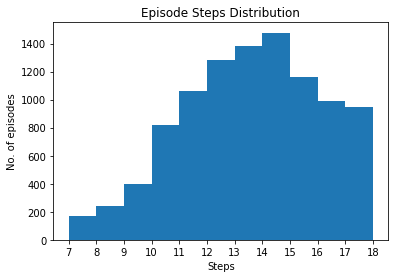

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
bins = [i + 1 for i in range(np.min(episode_dist), np.max(episode_dist))]

ax.hist(episode_dist, bins=bins)
ax.set_title("Episode Steps Distribution")
ax.set_xticks(bins)
ax.set_xlabel('Steps')
ax.set_ylabel('No. of episodes')
plt.show()